In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
%cd ../..
%pwd

c:\Users\jdu\Desktop\Projects\PipeRun


'c:\\Users\\jdu\\Desktop\\Projects\\PipeRun'

In [3]:
actions = [
    'stop',
    'walk'
]

data = np.concatenate([
    np.load('dataset/seq_stop_1633846512.npy'),
    np.load('dataset/seq_walk_1633846512.npy'),
], axis=0)

data.shape

(1142, 30, 173)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1142, 30, 172)
(1142,)


In [19]:
labels[0:5], labels[:-5]

(array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1142, 2)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1027, 30, 172) (1027, 2)
(115, 30, 172) (115, 2)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                60672     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 62,818
Trainable params: 62,818
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    callbacks=[
        ModelCheckpoint('models/walking_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/150
33/33 [==============================] - 2s 19ms/step - loss: 0.3299 - acc: 0.8432 - val_loss: 0.4148 - val_acc: 0.7391

Epoch 00001: val_acc improved from -inf to 0.73913, saving model to models\walking_model.h5
Epoch 2/150
33/33 [==============================] - 0s 12ms/step - loss: 0.2765 - acc: 0.9007 - val_loss: 0.7235 - val_acc: 0.6957

Epoch 00002: val_acc did not improve from 0.73913
Epoch 3/150
33/33 [==============================] - 0s 12ms/step - loss: 0.1567 - acc: 0.9435 - val_loss: 0.0224 - val_acc: 1.0000

Epoch 00003: val_acc improved from 0.73913 to 1.00000, saving model to models\walking_model.h5
Epoch 4/150
33/33 [==============================] - 0s 12ms/step - loss: 0.0620 - acc: 0.9805 - val_loss: 0.0079 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/150
33/33 [==============================] - 0s 13ms/step - loss: 0.0470 - acc: 0.9757 - val_loss: 0.1629 - val_acc: 0.9043

Epoch 00005: val_acc did not improve from 1.0000

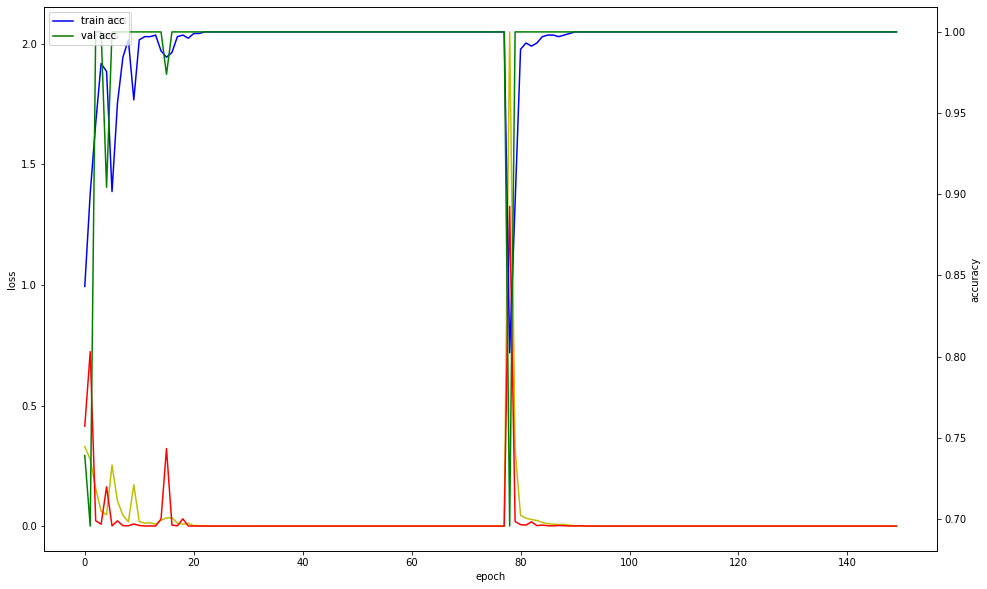

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/walking_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[67,  0],
        [ 0, 48]],

       [[48,  0],
        [ 0, 67]]], dtype=int64)

## TFlite Model Convert

In [11]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/walking_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jdu\AppData\Local\Temp\tmpyaeja5q9\assets
